# DSCI 100 Group Project Proposal: Bank Marketing Classification

### Introduction

### Preliminary Exploratory Data Analysis
#### Reading the Data

In [14]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [16]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip"

download.file(url, "bank.zip")
unzip("bank.zip")

bank_data <- read_delim("bank-full.csv", delim = ";")
bank_data

Rows: 45211 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (10): job, marital, education, default, housing, loan, contact, month, p...
dbl  (7): age, balance, day, duration, campaign, pdays, previous

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no
37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,other,no


*Table 1: Bank Marketing Dataset from the Web*

In [17]:
tidy_bank_data <- bank_data |>
    rename(term_deposit_success = y) |>
    mutate(term_deposit_success = as_factor(outcome))

bank_split <- initial_split(tidy_bank_data,
                            prop = 0.75,
                            strata = term_deposit_success)
bank_train <- training(bank_split)
bank_test <- testing(bank_split)

bank_train

age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,term_deposit_success
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
25,technician,single,secondary,no,505,no,yes,cellular,17,nov,386,2,-1,0,unknown,yes
51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes


*Table 2: Training Data Set*

#### Summary Statistics

In [19]:
missing_values <- data.frame(missing_values = sum(is.na(bank_train)))
missing_values

missing_values
<int>
0


*Table 3: Summary Table on Missing Values in the Data Set*

In [21]:
number_obs <- nrow(bank_train)
            bank_train |>
            group_by(term_deposit_success) |>
            summarize(Count = n(), Percentage = n() / number_obs * 100)

term_deposit_success,Count,Percentage
<fct>,<int>,<dbl>
no,29941,88.3033
yes,3966,11.6967


*Table 4: Summary Table on Variable Distribution*

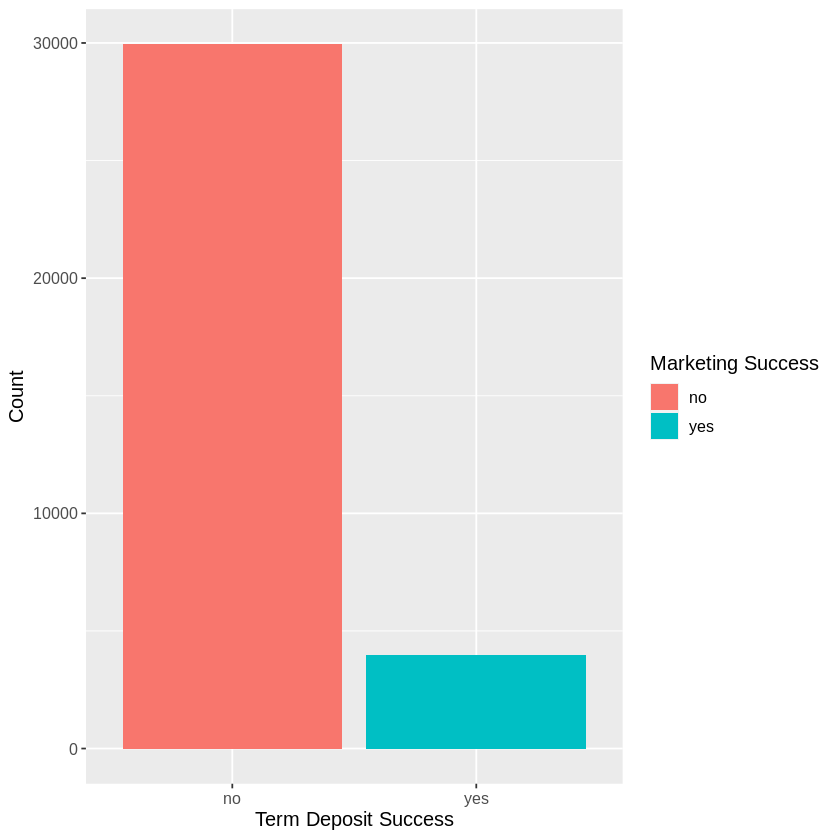

In [25]:
distribution_plot <- ggplot(bank_train, aes(x = term_deposit_success, fill = term_deposit_success)) +
            geom_bar(stat = "Count") +
            labs(x = "Term Deposit Success", y = "Count", fill = "Marketing Success") +
            theme(text = element_text(size = 12))                 
distribution_plot

*Figure 1: Distribution of Marketing Success*

### References

[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014.